<a href="https://colab.research.google.com/github/arman258/CNG-562/blob/master/Cactus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [14]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"arman258","key":"c7ce25b195167eea26aab042b429be00"}'}

In [0]:
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
!curl x-s https://course.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0curl: (6) Could not resolve host: x-s
100   321  100   321    0     0   9171      0 --:--:-- --:--:-- --:--:--  9171
Updating fastai...
Done.


In [0]:
!kaggle competitions download aerial-cactus-identification -p cactus -q

In [0]:
# !rm -rf cactus/train

In [0]:
!unzip -qq cactus/test -d cactus 
!unzip -qq cactus/train -d cactus 

In [10]:
aimport torch
torch.backends.cudnn.enabled
from fastai.vision import *
from fastai.metrics import *

import numpy as np
import pandas as pd

print(torch.cuda.is_available())


True


In [0]:
train="cactus/train/"
test="cactus/test"

df_train=pd.read_csv('cactus/train.csv')

df_test=pd.read_csv('cactus/sample_submission.csv')

In [20]:
df_train.count()

id            17500
has_cactus    17500
dtype: int64

In [21]:
df_train['has_cactus'].value_counts()


1    13136
0     4364
Name: has_cactus, dtype: int64

In [19]:
df_test.count()

id            4000
has_cactus    4000
dtype: int64

In [0]:
trfm = get_transforms(do_flip=True, flip_vert=True, max_rotate=20, max_zoom=1.1)


In [0]:
test_img = ImageList.from_df(df_test, path=test)
                   

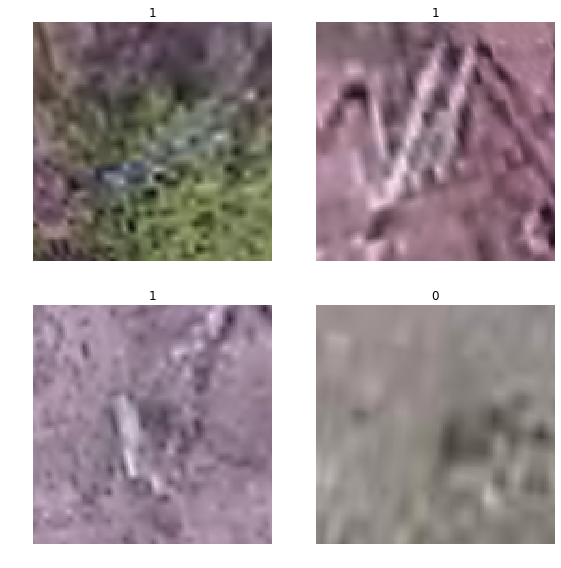

In [68]:
train_img = (ImageList.from_df(df_train, path=train)
        .split_by_rand_pct(0.01)
        .label_from_df()
        .add_test(test_img)
        .transform(trfm, size=128)
        .databunch(path='.', bs=64, device= torch.device('cuda:0'))
        .normalize(imagenet_stats)
       )
train_img.show_batch(rows=2, figsize=(8,8))

In [69]:
learn = cnn_learner(train_img, models.densenet161, metrics=[error_rate, accuracy])


Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/checkpoints/densenet161-8d451a50.pth
100%|██████████| 115730790/115730790 [00:00<00:00, 119497215.09it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


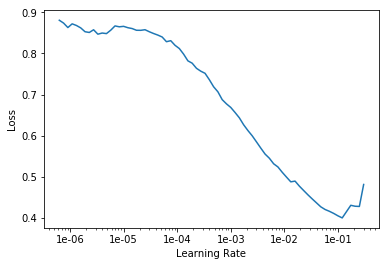

In [70]:
learn.lr_find()
learn.recorder.plot()

In [71]:
lr = 1.25e-02
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.048475,0.027280,0.011429,0.988571,01:35
1,0.027893,0.000338,0.000000,1.000000,01:35
2,0.015195,0.000104,0.000000,1.000000,01:36
3,0.003246,0.000131,0.000000,1.000000,01:37
4,0.003305,0.000062,0.000000,1.000000,01:37


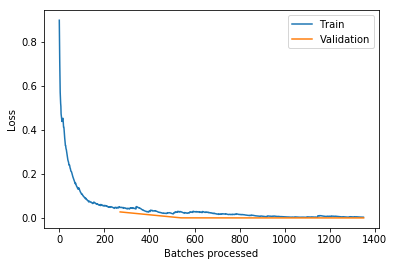

In [72]:
learn.recorder.plot_losses()


In [0]:
interp = ClassificationInterpretation.from_learner(learn)


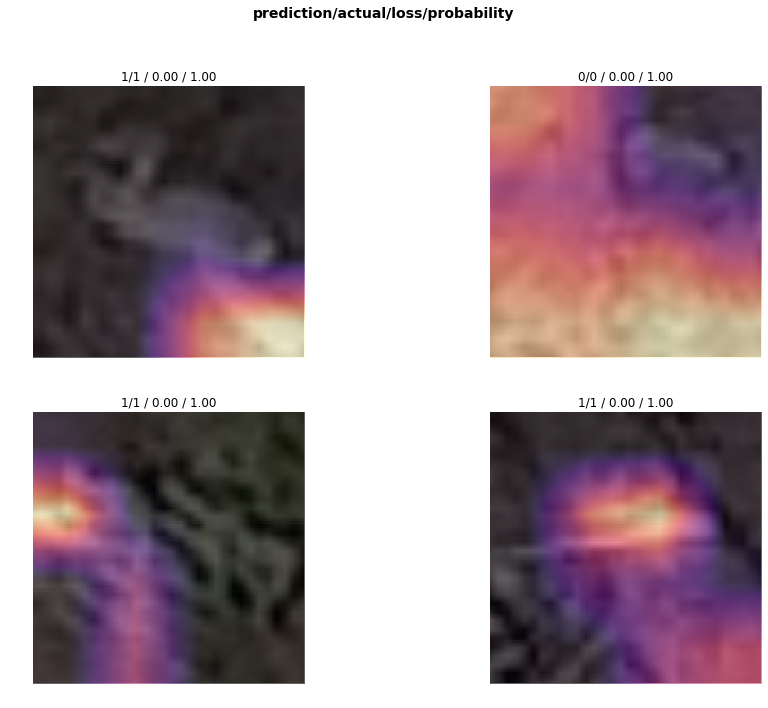

In [74]:
interp.plot_top_losses(4, figsize=(15,11))


In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator


import matplotlib.pyplot as plt 
import numpy as np

import cv2
import glob
import os


from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [0]:
data_gen = ImageDataGenerator(rescale=1./255)

In [0]:
df_train.has_cactus=df_train.has_cactus.astype(str)
df_test.has_cactus=df_train.has_cactus.astype(str)

In [144]:
train_generator=data_gen.flow_from_dataframe(dataframe=df_train[:15001],directory=train,x_col='id',
                                                y_col='has_cactus',class_mode='binary',batch_size=150,
                                                target_size=(150,150))

test_generator=data_gen.flow_from_dataframe(dataframe=df_train[15000:],directory=train,x_col='id',
                                                y_col='has_cactus',class_mode='binary',batch_size=50,
                                                target_size=(150,150))

Found 15001 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [0]:
inputShape= (150,150,3)


In [142]:
model = Sequential()
model.add(Conv2D(32, kernel_size=5, padding="same", input_shape=inputShape, activation = 'relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Conv2D(64, kernel_size=3, padding="same", activation = 'relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Conv2D(128, kernel_size=3, padding="same", activation = 'relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))


model.add(Flatten())
model.add(Dense(units=30, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=10, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=5, activation='relu'))
#model.add(Dropout(0.1))

model.add(Dense(1))
model.add(Activation("sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 150, 150, 32)      2432      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 74, 74, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 36, 36, 128)       73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 36992)             0         
__________

In [145]:
H=model.fit_generator(train_generator,steps_per_epoch=100,epochs=20,validation_data=test_generator,validation_steps=50)

Epoch 1/20
100/100 [==============================] - 17s 169ms/step - loss: 0.3009 - acc: 0.8749 - val_loss: 0.1968 - val_acc: 0.9392
Epoch 2/20
100/100 [==============================] - 14s 141ms/step - loss: 0.1687 - acc: 0.9377 - val_loss: 0.1357 - val_acc: 0.9588
Epoch 3/20
100/100 [==============================] - 15s 146ms/step - loss: 0.1258 - acc: 0.9563 - val_loss: 0.1492 - val_acc: 0.9468
Epoch 4/20
100/100 [==============================] - 14s 139ms/step - loss: 0.0871 - acc: 0.9682 - val_loss: 0.0817 - val_acc: 0.9712
Epoch 5/20
100/100 [==============================] - 14s 137ms/step - loss: 0.0827 - acc: 0.9717 - val_loss: 0.0885 - val_acc: 0.9640
Epoch 6/20
100/100 [==============================] - 14s 138ms/step - loss: 0.0585 - acc: 0.9799 - val_loss: 0.0811 - val_acc: 0.9700
Epoch 7/20
100/100 [==============================] - 14s 138ms/step - loss: 0.0561 - acc: 0.9819 - val_loss: 0.0408 - val_acc: 0.9852
Epoch 8/20
100/100 [==============================] - 1

In [0]:
import tensorflow as tf


In [147]:
vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', input_shape=(150,150,3))
vgg.trainable = False
for layer in vgg.layers:
    layer.trainable = False
    
base_vgg = vgg
base_out = base_vgg.output
pool_out = tf.keras.layers.Flatten()(base_out)
hidden1 = tf.keras.layers.Dense(512, activation='relu')(pool_out)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=base_vgg.input, outputs=out)
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-5),
                loss='binary_crossentropy',
                metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [150]:
H_vgg=model.fit_generator(train_generator,steps_per_epoch=100,epochs=15,validation_data=test_generator,validation_steps=50)

Epoch 1/15
101/101 [==============================] - 52s 513ms/step - loss: 0.0775 - acc: 0.9717 - val_loss: 0.0821 - val_acc: 0.9716
Epoch 2/15
101/101 [==============================] - 54s 530ms/step - loss: 0.0740 - acc: 0.9707 - val_loss: 0.0800 - val_acc: 0.9724
Epoch 3/15
101/101 [==============================] - 55s 540ms/step - loss: 0.0714 - acc: 0.9729 - val_loss: 0.0770 - val_acc: 0.9724
Epoch 4/15
101/101 [==============================] - 55s 542ms/step - loss: 0.0687 - acc: 0.9743 - val_loss: 0.0750 - val_acc: 0.9728
Epoch 5/15
101/101 [==============================] - 55s 542ms/step - loss: 0.0663 - acc: 0.9756 - val_loss: 0.0737 - val_acc: 0.9756
Epoch 6/15
101/101 [==============================] - 55s 542ms/step - loss: 0.0654 - acc: 0.9755 - val_loss: 0.0771 - val_acc: 0.9692
Epoch 7/15
101/101 [==============================] - 55s 542ms/step - loss: 0.0629 - acc: 0.9775 - val_loss: 0.0714 - val_acc: 0.9728
Epoch 8/15
101/101 [==============================] - 5

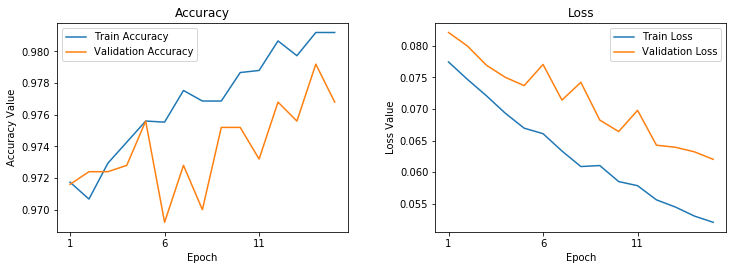

In [151]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(H_vgg.history['acc'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, H_vgg.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, H_vgg.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, H_vgg.history['loss'], label='Train Loss')
ax2.plot(epoch_list, H_vgg.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")